Pendahuluan Setup

In [1]:
# 1. Import library dasar
import pandas as pd
import os

In [2]:
# 2. Load semua dataset utama
customers = pd.read_csv("/content/olist_customers_dataset.csv")
orders = pd.read_csv("/content/olist_orders_dataset.csv")
order_items = pd.read_csv("/content/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/content/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/content/olist_order_reviews_dataset.csv")
products = pd.read_csv("/content/olist_products_dataset.csv")
sellers = pd.read_csv("/content/olist_sellers_dataset.csv")
geolocation = pd.read_csv("/content/olist_geolocation_dataset.csv")
category_translation = pd.read_csv("/content/product_category_name_translation.csv")

In [3]:
# 3. Cek informasi dasar tiap dataset
print("\n--- Customers ---")
print(customers.info(), "\n")
print(customers.head())

print("\n--- Orders ---")
print(orders.info(), "\n")
print(orders.head())


--- Customers ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None 

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   


In [4]:
# 4. Dokumentasi awal - Insighth singkat
print(f"Jumlah total customers: {customers['customer_id'].nunique()}")
print(f"Jumlah total orders: {orders['order_id'].nunique()}")
print(f"Rentang waktu order: {orders['order_purchase_timestamp'].min()} - {orders['order_purchase_timestamp'].max()}")

Jumlah total customers: 99441
Jumlah total orders: 99441
Rentang waktu order: 2016-09-04 21:15:19 - 2018-10-17 17:30:18


ETL - Extract, Transform, Load

In [5]:
# 5. Transform: Cleaning dasar
# Convert date columns ke datetime
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])

# Gabungkan products dengan terjemahan kategori
products = products.merge(category_translation, how="left", left_on="product_category_name", right_on="product_category_name")
products["product_category_name_english"] = products["product_category_name_english"].fillna("unknown")

# Buat kolom revenue di order_items
order_items["revenue"] = order_items["price"] * order_items["order_item_id"]

In [6]:
# 6. Join: Bentuk Fact Table Sales
fact_sales = (
    order_items
    .merge(orders[["order_id", "customer_id", "order_purchase_timestamp", "order_status", "order_delivered_customer_date"]], on="order_id", how="left")
    .merge(customers[["customer_id", "customer_unique_id", "customer_city", "customer_state"]], on="customer_id", how="left")
    .merge(products[["product_id", "product_category_name_english"]], on="product_id", how="left")
    .merge(sellers[["seller_id", "seller_city", "seller_state"]], on="seller_id", how="left")
    .merge(order_payments.groupby("order_id")["payment_value"].sum().reset_index(), on="order_id", how="left")
    .merge(order_reviews.groupby("order_id")["review_score"].mean().reset_index(), on="order_id", how="left")
)

In [7]:
# 7. Buat Dimension Tables
dim_customers = customers.drop_duplicates("customer_id")
dim_products = products[["product_id", "product_category_name_english"]].drop_duplicates()
dim_sellers = sellers.drop_duplicates("seller_id")

# Dim_date: generate dari min-max purchase date
date_range = pd.date_range(orders["order_purchase_timestamp"].min(), orders["order_purchase_timestamp"].max())
dim_date = pd.DataFrame({
    "date": date_range,
    "date_id": date_range.strftime("%Y%m%d").astype(int),
    "year": date_range.year,
    "month": date_range.month,
    "day": date_range.day,
    "weekday": date_range.weekday,
})

In [8]:
# 8. Load: Simpan hasil ke folder warehouse_csv
output_dir = "./warehouse_csv"
os.makedirs(output_dir, exist_ok=True)

fact_sales.to_csv(os.path.join(output_dir, "fact_sales.csv"), index=False)
dim_customers.to_csv(os.path.join(output_dir, "dim_customers.csv"), index=False)
dim_products.to_csv(os.path.join(output_dir, "dim_products.csv"), index=False)
dim_sellers.to_csv(os.path.join(output_dir, "dim_sellers.csv"), index=False)
dim_date.to_csv(os.path.join(output_dir, "dim_date.csv"), index=False)

print("✅ ETL selesai! Hasil tersimpan di folder warehouse_csv")

✅ ETL selesai! Hasil tersimpan di folder warehouse_csv


EDA

In [9]:
# 1. Info dasar dataset
import matplotlib.pyplot as plt
import seaborn as sns

print(fact_sales.info())
print(fact_sales.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  object        
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   revenue                        112650 non-null  float64       
 8   customer_id                    112650 non-null  object        
 9   order_purchase_timestamp       112650 non-null  datetime64[ns]
 10  order_status                   112650 non-null  object        
 11  

/tmp/ipython-input-3911356023.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_status_counts.index, y=order_status_counts.values, palette="viridis")


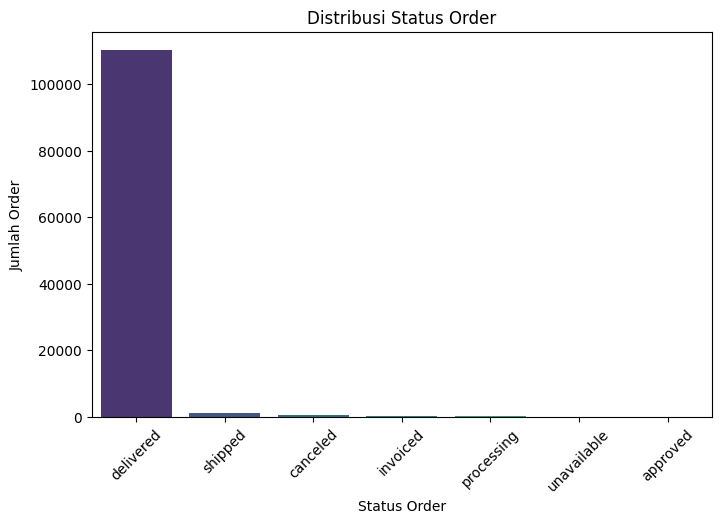

In [10]:
# 2. Distribusi status order
order_status_counts = fact_sales['order_status'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=order_status_counts.index, y=order_status_counts.values, palette="viridis")
plt.title("Distribusi Status Order")
plt.ylabel("Jumlah Order")
plt.xlabel("Status Order")
plt.xticks(rotation=45)
plt.show()

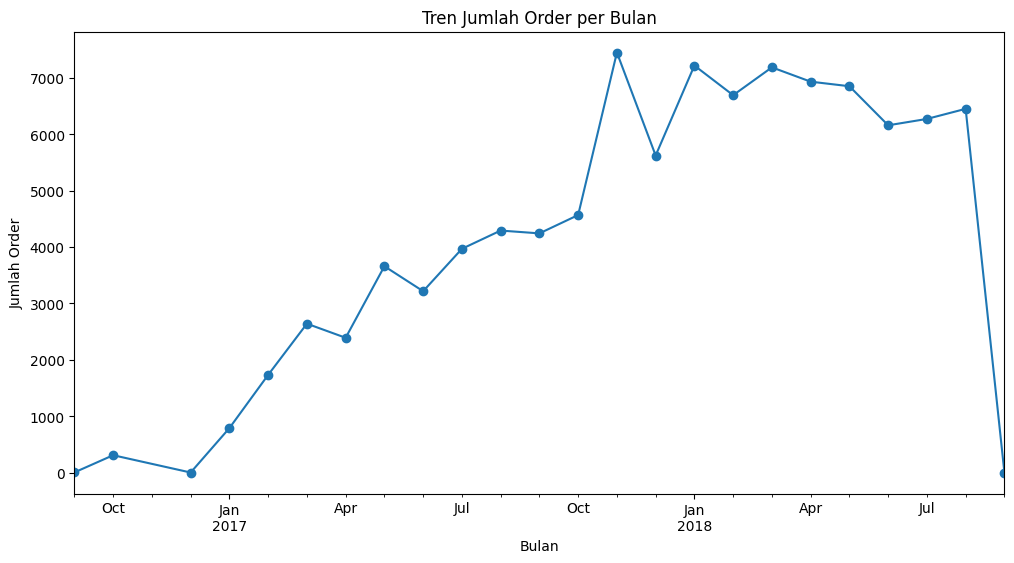

In [11]:
# 3. Tren jumlah order per bulan
fact_sales['order_month'] = fact_sales['order_purchase_timestamp'].dt.to_period("M")
monthly_orders = fact_sales.groupby("order_month")['order_id'].nunique()

plt.figure(figsize=(12,6))
monthly_orders.plot(kind="line", marker="o")
plt.title("Tren Jumlah Order per Bulan")
plt.ylabel("Jumlah Order")
plt.xlabel("Bulan")
plt.show()

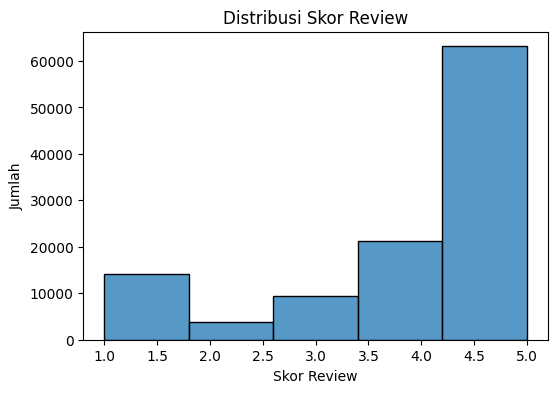

In [12]:
# 4. Rating distribusi
plt.figure(figsize=(6,4))
sns.histplot(fact_sales['review_score'], bins=5, kde=False)
plt.title("Distribusi Skor Review")
plt.xlabel("Skor Review")
plt.ylabel("Jumlah")
plt.show()

/tmp/ipython-input-110596187.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette="mako")


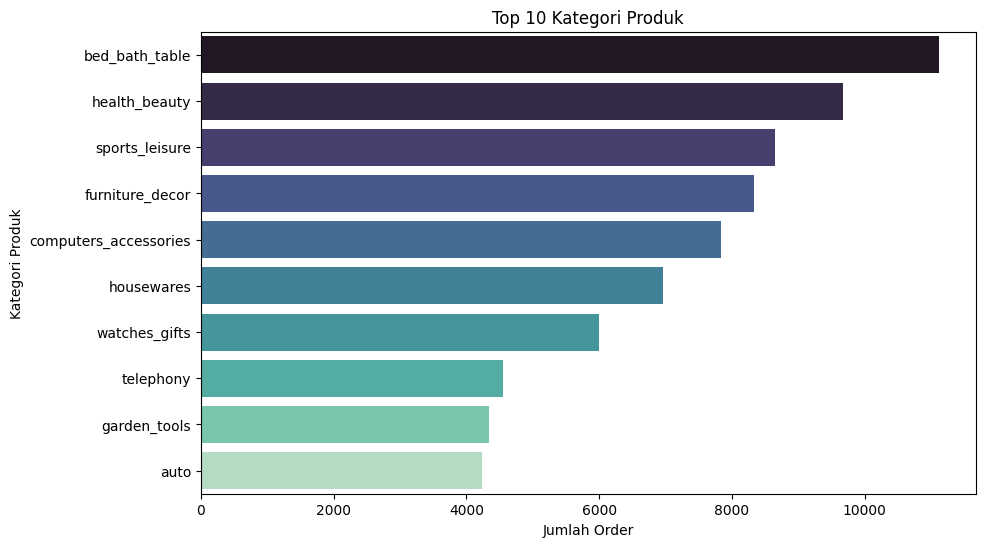

In [13]:
# 5. Top 10 kategori produk
top_categories = fact_sales['product_category_name_english'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(y=top_categories.index, x=top_categories.values, palette="mako")
plt.title("Top 10 Kategori Produk")
plt.xlabel("Jumlah Order")
plt.ylabel("Kategori Produk")
plt.show()

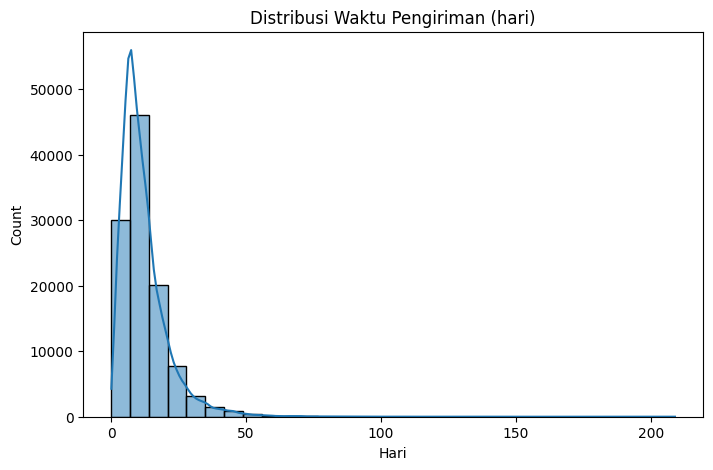

In [14]:
# 6. Rata-rata waktu pengiriman
fact_sales['delivery_time_days'] = (fact_sales['order_delivered_customer_date'] - fact_sales['order_purchase_timestamp']).dt.days
plt.figure(figsize=(8,5))
sns.histplot(fact_sales['delivery_time_days'].dropna(), bins=30, kde=True)
plt.title("Distribusi Waktu Pengiriman (hari)")
plt.xlabel("Hari")
plt.show()